# American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This excercise focuses on classifying a subset of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters A-I, we want to detect which letter is being represented.

![](https://drive.google.com/uc?export=view&id=1C8r-cwHSbpK2bD4n-00XzKhwuPN1ZOQv)

## Data Loading
The data for this excercise is present in "[asl_data.zip](https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0)". The dataset contains 9 classes (images corresponding to characters A to I). For convenience, the dataset is structured in such a way that we can use TorchVision's ImageFolder dataset [(documentation)](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) rather than writing your own custom dataset loader.

In [1]:
# Define the standard imports
from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy

In [2]:
# Download the data in the current working directory
!rm -rf asl_data.zip asl_data
!wget -O asl_data.zip https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
!unzip asl_data.zip
!rm asl_data.zip

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./asl_data"

# Define the class label
class_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I'}

--2020-11-16 15:11:39--  https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r75maq5e1vyda4g/asl_data.zip [following]
--2020-11-16 15:11:39--  https://www.dropbox.com/s/raw/r75maq5e1vyda4g/asl_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08bfa63ab9e1038e6dc33b6035.dl.dropboxusercontent.com/cd/0/inline/BDU7i-mpq9Xg7Qw0s26AZeXVZTOe8J_SifHDuWEQfBKFk4-5bc6UlX3V-996qPlNJZ8q554qZ2_lMhDWmnaKGVBX-9tO77ZAsCf8k9WpBhVQwWoHjPyAqFnKl9huKmasZxg/file# [following]
--2020-11-16 15:11:39--  https://uc08bfa63ab9e1038e6dc33b6035.dl.dropboxusercontent.com/cd/0/inline/BDU7i-mpq9Xg7Qw0s26AZeXVZTOe8J_SifHDuWEQfBKFk4-5bc6UlX3V-996qPlNJZ8q554qZ2_lMhDWmnaKGVBX-9tO77ZAsCf8k9WpBh

## Visualize the data

We will now see how the sample data looks like

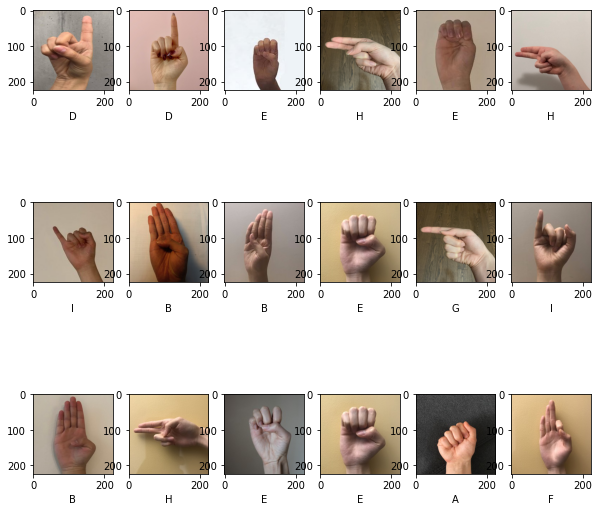

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms.ToTensor()) for x in ['train', 'val']}
val_dataloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=True)
train_dataloader=torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=True)
f = plt.figure(figsize=(10, 10))
for i in range(18):
    img, label = next(iter(val_dataloader))
    img = img.squeeze().permute(1,2,0).numpy()
    plt.subplot(3,6,i+1)
    plt.imshow(img)
    plt.xlabel(class_dict[label.numpy()[0]])


# Excercise: Neural Network

In this excercise you will be using a neural network. You are free to use one of the pretrained model, as demonstrated in the previous lab, or write your own neural network from scratch.

You may use the PyTorch documentation, previous excercises and notebooks freely. You might find documentations and notebooks discussed in the last two classes helpful. However, all code and analysis that you submit must be your own.


### **Questions**
**Question 1: Model Building**

Build a multi-layered perceptron (MLP) in Pytorch that inputs  that takes the (224x224 RGB) image as input, and predicts the letter (You may need to flatten the image vector first). Your model should be a subclass of `nn.Module`. Explain your choice of neural network architecture: how many layers your network has? What types of layers does it contain? What about other decisions like use of dropout layers, activation functions, number of channels / hidden units.

**Question 2: Training Code** 

Write code to train your neural network given some training data. Your training code should make it easy to tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function. Ensure that your code runs on GPU.


**Question 3: Overfit to a Small Dataset** 

**Part (a)**: One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or your training code. Fix the issues before you proceed to the next step.

**Part (b)**: Once you are done with the above part, try to reduce the effect of overfitting by using techniques discussed in the previous lecture.

**Question 4: Finetuning** 

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

In this part, you will use Transfer Learning to extract features from the hand gesture images. Then, train last few classification layers to use these features as input and classify the hand gestures. As you have learned in the previous lecture, you can use AlexNet architecture that is pretrained on 1000-class ImageNet dataset and finetune it for the task of understanding American sign language.

**Question 5: Report result** 

Train your new network, including any hyperparameter tuning. Plot and submit the training and validation loss and accuracy of your best model only. Along with it, also submit the final validation accuracy achieved by your model.


# Question 1: Model Building

Build a multi-layered perceptron (MLP) in Pytorch that inputs that takes the (224x224 RGB) image as input, and predicts the letter (You may need to flatten the image vector first). Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how many layers your network has? What types of layers does it contain? What about other decisions like use of dropout layers, activation functions, number of channels / hidden units.

In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Initialize all the layers with learnable parameters
        self.layer1 = nn.Linear(3 * 224 * 224, 128 * 3)
        self.layer2 = nn.Linear(128 * 3, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 9)

    def forward(self, img):
        flattened = img.view(-1, 3 * 224 * 224)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        activation4 = F.relu(self.layer4(activation3))
        out = self.layer5(activation4)
        return out

model = Net()

In [5]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 10)

weights_init(model)
len(list(model.parameters()))

10

# Question 2: Training Code

Write code to train your neural network given some training data. Your training code should make it easy to tweak hyperparameters. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function. Ensure that your code runs on GPU.

In [6]:
def trainval(model, train_data, valid_data, device, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.5, weight_decay=weight_decay)

    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for n in range(num_iters):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            #print(imgs.shape)

            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            if n % 10 == 9:
                
                iters.append(n)
                loss = float(loss)/batch_size
                losses.append(loss)        # compute *average* loss
                train_accuracy = get_accuracy(model, train_data, device)
                val_accuracy = get_accuracy(model, valid_data, device)
                for im, lb in val_loader:
                    im, lb = im.to(device), lb.to(device)
                    val_out = model(im)
                    val_loss = criterion(val_out, lb)
                val_losses.append(float(val_loss)/batch_size)
                train_acc.append(train_accuracy) # compute training accuracy 
                val_acc.append(val_accuracy)   # compute validation accuracy
                print('iter '+str(n)+' loss '+ str(loss)+ ' train accuracy '+str(train_accuracy) +' val accuracy '+str(val_accuracy)+'\n')
            # # Apply early stopping
            # i = len(val_acc)
            # if(val_acc[i-1]<val_acc[i-2] or train_acc[i-1]<train_acc[i-2] ):
            #   break
    print()
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve:Loss")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.ylim((0,1.1))
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def get_accuracy(model, data, device):
    correct = 0
    total = 0

    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        # print("Pred:", pred,"\nLabels:", labels)
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

# Question 3: Overfit to a Small Dataset

## Part a: 

One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting a small dataset. Construct a small dataset (e.g. 1-2 image per class). Then show that your model and training code is capable of overfitting on that small dataset. You should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

If your model cannot overfit the small dataset quickly, then there is a bug in either your model code and/or your training code. Fix the issues before you proceed to the next step.

In [7]:
data = list(image_datasets['train'])
sign_test = list(image_datasets['val'])

In [22]:
def get_count(sign_data):
  cur=0
  count= [] 
  location= [] 
  for i in range(9):
    location.append(0)
    count.append(0)
  for i in range(len(sign_data)): 
    if(sign_data[i][1]!=cur):
      cur=sign_data[i][1]
      location[sign_data[i][1]]=i
    count[sign_data[i][1]]+=1
  return count, location
count, location = get_count(data)
print(location)
print(count)

[0, 108, 215, 307, 414, 506, 612, 714, 818]
[108, 107, 92, 107, 92, 106, 102, 104, 113]


In [10]:
import random
random.seed(0)
num_train = 2
num_val = 20
sign_train = list()
for i in range(9):
  sign_train+= data[location[i]:location[i]+num_train]

sign_val = list()
for i in range(9):
  sign_val+= data[location[i]+num_train:location[i]+num_val+num_train]
## shuffle data for better sampling
random.shuffle(sign_train)
random.shuffle(sign_val)

print('Number of training images: {}'.format(len(sign_train)))
print('Number of validation images: {}'.format(len(sign_val)))


Number of training images: 18
Number of validation images: 180


In [11]:
count, location = get_count(sign_train)
print("train")
print(location)
print(count)
count, location = get_count(sign_val)
print("val")
print(location)
print(count)

train
[15, 7, 14, 11, 13, 6, 16, 10, 9]
[2, 2, 2, 2, 2, 2, 2, 2, 2]
val
[174, 177, 164, 176, 173, 168, 179, 178, 170]
[20, 20, 20, 20, 20, 20, 20, 20, 20]


iter 9 loss 0.10913697481155396 train accuracy 0.1111111111111111 val accuracy 0.1111111111111111

iter 19 loss 0.1076322317123413 train accuracy 0.1111111111111111 val accuracy 0.1111111111111111

iter 29 loss 0.10516109466552734 train accuracy 0.3333333333333333 val accuracy 0.11666666666666667

iter 39 loss 0.10146180391311646 train accuracy 0.5 val accuracy 0.18333333333333332

iter 49 loss 0.09568384885787964 train accuracy 0.5 val accuracy 0.17777777777777778

iter 59 loss 0.08535733819007874 train accuracy 0.6666666666666666 val accuracy 0.2111111111111111

iter 69 loss 0.072587651014328 train accuracy 0.7222222222222222 val accuracy 0.25

iter 79 loss 0.07896583676338195 train accuracy 0.2222222222222222 val accuracy 0.16666666666666666

iter 89 loss 0.0868107557296753 train accuracy 0.3888888888888889 val accuracy 0.25

iter 99 loss 0.040128952264785765 train accuracy 0.8333333333333334 val accuracy 0.16666666666666666

iter 109 loss 0.06045970320701599 train accuracy 0.666666

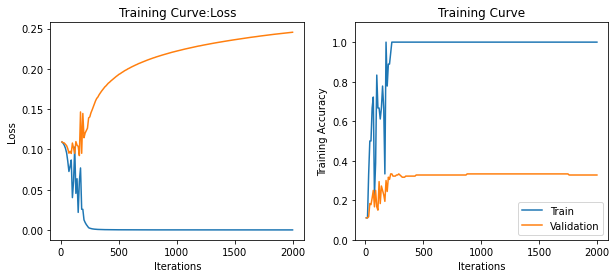

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.3277777777777778


In [12]:
model = Net()

# Ship data and model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

trainval(model, sign_train, sign_val, device, num_iters=2000)

## Part b
Once you are done with the above part, try to reduce the effect of overfitting by using techniques discussed in the previous lecture.

In [13]:
# augment dataset (using the available data only)
num_train_new = 1
sign_train_new = sign_train
for i in range(9):
  sign_train_new+= data[location[i]+num_train+num_val:location[i]+num_train+num_val+num_train_new]
random.shuffle(sign_train_new)

iter 9 loss 0.09552416801452637 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 9 loss 0.11284011602401733 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 19 loss 0.09187868237495422 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 19 loss 0.1015360951423645 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 29 loss 0.09733308553695678 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 29 loss 0.09566161036491394 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 39 loss 0.08323521614074707 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 39 loss 0.08853555321693421 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 49 loss 0.06745442748069763 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

iter 49 loss 0.10913598537445068 train accuracy 0.4074074074074074 val accuracy 0.1111111111111111

ite

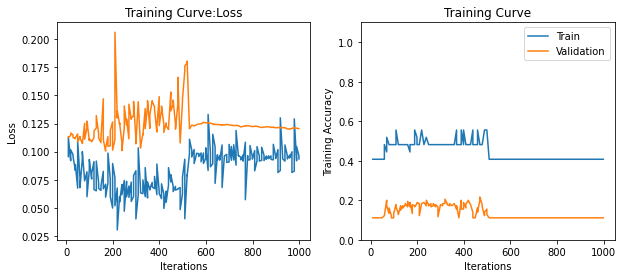

Final Training Accuracy: 0.4074074074074074
Final Validation Accuracy: 0.1111111111111111


In [14]:
# using dropout and weight decay
class signClassifierWithDropout(nn.Module):
    def __init__(self):
        super(signClassifierWithDropout, self).__init__()

        self.layer1 = nn.Linear(3 * 224 * 224, 128 * 2)
        self.layer2 = nn.Linear(128 * 2, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 9)

        self.dropout1 = nn.Dropout(0.3) # drop out layer with 30% dropped out neuron
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.3)

    def forward(self, img):
        flattened = img.view(-1, 3 * 224 * 224)
        #print(flattened.shape)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        activation3 = F.relu(self.layer3(self.dropout3(activation2)))
        activation4 = F.relu(self.layer4(self.dropout3(activation3)))

        output = self.layer5(activation4)
        return output

model = signClassifierWithDropout()
model.to(device)

trainval(model, sign_train_new, sign_val, device, num_iters=1000,  weight_decay=0.01)

# Question 4: Finetuning

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

In this part, you will use Transfer Learning to extract features from the hand gesture images. Then, train last few classification layers to use these features as input and classify the hand gestures. As you have learned in the previous lecture, you can use AlexNet architecture that is pretrained on 1000-class ImageNet dataset and finetune it for the task of understanding American sign language.



In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Alexnet
    """
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_name = "alexnet"
num_classes = 9
feature_extract = True
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [18]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [19]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4) for x in ['train', 'val']}
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.5588 Acc: 0.4157
val Loss: 1.2214 Acc: 0.5733

Epoch 1/19
----------
train Loss: 0.9781 Acc: 0.6423
val Loss: 0.7774 Acc: 0.7069

Epoch 2/19
----------
train Loss: 0.7118 Acc: 0.7358
val Loss: 0.7288 Acc: 0.6767

Epoch 3/19
----------
train Loss: 0.6748 Acc: 0.7487
val Loss: 0.6655 Acc: 0.7198

Epoch 4/19
----------
train Loss: 0.6872 Acc: 0.7411
val Loss: 0.7017 Acc: 0.7155

Epoch 5/19
----------
train Loss: 0.5883 Acc: 0.7820
val Loss: 0.5440 Acc: 0.7629

Epoch 6/19
----------
train Loss: 0.4956 Acc: 0.8185
val Loss: 0.7155 Acc: 0.7198

Epoch 7/19
----------
train Loss: 0.5899 Acc: 0.7734
val Loss: 0.5147 Acc: 0.7500

Epoch 8/19
----------
train Loss: 0.5143 Acc: 0.8024
val Loss: 0.5685 Acc: 0.7586

Epoch 9/19
----------
train Loss: 0.5275 Acc: 0.7927
val Loss: 0.5288 Acc: 0.7759

Epoch 10/19
----------
train Loss: 0.4654 Acc: 0.8238
val Loss: 0.5688 Acc: 0.7845

Epoch 11/19
----------
train Loss: 0.5269 Acc: 0.8120
val Loss: 0.5523 Acc: 0.7974

Ep

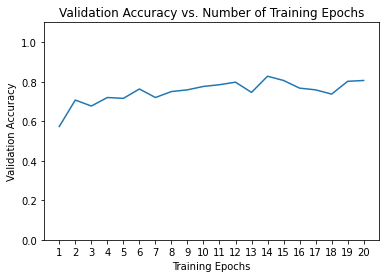

In [20]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,21),hist)
plt.ylim((0,1.1))
plt.xticks(np.arange(1, 21, 1.0))
#plt.legend()
plt.show()

# Question 5: Report result

Train your new network, including any hyperparameter tuning. Plot and submit the training and validation loss and accuracy of your best model only. Along with it, also submit the final validation accuracy achieved by your model.

Epoch 0/19
----------
train Loss: 2.1976 Acc: 0.1106
val Loss: 2.1972 Acc: 0.1078

Epoch 1/19
----------
train Loss: 2.1973 Acc: 0.1053
val Loss: 2.1970 Acc: 0.1121

Epoch 2/19
----------
train Loss: 2.1969 Acc: 0.1117
val Loss: 2.1967 Acc: 0.1121

Epoch 3/19
----------
train Loss: 2.1969 Acc: 0.1106
val Loss: 2.1965 Acc: 0.1207

Epoch 4/19
----------
train Loss: 2.1967 Acc: 0.1214
val Loss: 2.1963 Acc: 0.1207

Epoch 5/19
----------
train Loss: 2.1965 Acc: 0.1214
val Loss: 2.1961 Acc: 0.1207

Epoch 6/19
----------
train Loss: 2.1961 Acc: 0.1214
val Loss: 2.1960 Acc: 0.1207

Epoch 7/19
----------
train Loss: 2.1960 Acc: 0.1214
val Loss: 2.1959 Acc: 0.1207

Epoch 8/19
----------
train Loss: 2.1960 Acc: 0.1214
val Loss: 2.1957 Acc: 0.1207

Epoch 9/19
----------
train Loss: 2.1958 Acc: 0.1214
val Loss: 2.1956 Acc: 0.1207

Epoch 10/19
----------
train Loss: 2.1958 Acc: 0.1214
val Loss: 2.1956 Acc: 0.1207

Epoch 11/19
----------
train Loss: 2.1957 Acc: 0.1214
val Loss: 2.1955 Acc: 0.1207

Ep

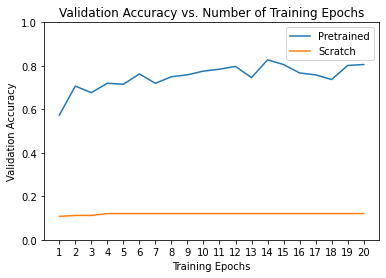

In [21]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=20)

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]
num_epochs = 20
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()